In [161]:
import pickle
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
import string
import wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline 

from imblearn.over_sampling import RandomOverSampler
import imblearn.pipeline as imblearnpipeline

import pandas as pd
import numpy as np
from PIL import Image
from os import path
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns


In [145]:
def calc_and_display_performance_metric(classifer, Xtest, ytest, Xtrain, ytrain, classifier_predictions, class_label_names):
    '''Calcuate and display peformance metrics for a classifier.'''
    # Metrics - on how well the classifer performed on test data AND getting metrics on training data to check for model overfitting.
    train_predictions = classifer.predict(Xtrain)
    show_peformance_metrics(ytrain, train_predictions, Xtest, ytest, classifier_predictions, class_label_names)
    # Confusion Matrix
    plot_pretty_cf(classifer, Xtest, ytest)

def show_peformance_metrics(y_train, y_train_pred, X_test, y_test, y_pred, names):
    ''' Print out peformance metrics'''
    train_score = accuracy_score(y_train, y_train_pred)
    test_score = accuracy_score(y_test, y_pred)
    print('--------------------------------------------------------------------------')
    print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(train_score, test_score))
    print('--------------------------------------------------------------------------')
    print(classification_report(y_test, y_pred, target_names=names))
    print('--------------------------------------------------------------------------')

def plot_pretty_cf(predictor, Xtest, ytest, cmap='Blues', normalize='true', title=None):
    ''' Plot a pretty confusion matrix '''
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_confusion_matrix(predictor, Xtest, ytest, cmap=cmap, normalize=normalize, ax=ax)
    ax.set_title(title, size='large')
    ax.set_xlabel('Predicted Label', size='medium')
    ax.set_ylabel('True Label', size='medium')
    plt.show()

In [90]:
jun_2020_tweets = pd.read_csv('../data/us_only_external_data_tweets_TOOL_labeled.csv')
jan_2021_tweets_qh = pd.read_csv('../data/jan_2021_queried_tweets_HUMAN_labeled.csv')
jan_2021_tweets_q = pd.read_csv('../data/jan_2021_queried_tweets_TOOL_labeled.csv')
jan_2021_tweets_s = pd.read_csv('../data/jan_2021_streaming_tweets_TOOL_labeled.csv')

tweets_df = jun_2020_tweets.append(jan_2021_tweets_qh)
tweets_df.append(jan_2021_tweets_q)
tweets_df.append(jan_2021_tweets_s)

tweets_df.info()
tweets_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38392 entries, 0 to 347
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        38044 non-null  float64
 1   the_id            38044 non-null  float64
 2   content           38392 non-null  object 
 3   user_loc          38392 non-null  object 
 4   user_screen_name  38392 non-null  object 
 5   retweet_count     38392 non-null  int64  
 6   fav_count         38392 non-null  int64  
 7   created_at        38392 non-null  object 
 8   char_count        38392 non-null  int64  
 9   sentiment_method  38392 non-null  object 
 10  sentiment         38392 non-null  object 
 11  _id               348 non-null    object 
 12  id_str            348 non-null    float64
dtypes: float64(3), int64(3), object(7)
memory usage: 4.1+ MB


(38392, 13)

In [92]:
tweets_df = tweets_df[['content', 'sentiment']]
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38392 entries, 0 to 347
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    38392 non-null  object
 1   sentiment  38392 non-null  object
dtypes: object(2)
memory usage: 899.8+ KB


In [97]:
tweets_df['sentiment'].value_counts()
# We have class imbalance here with many more positive tweets

positive    28259
neutral      6064
negative     4069
Name: sentiment, dtype: int64

In [96]:
pos_neg_tweets = tweets_df[tweets_df['sentiment'] != 'neutral']
pos_neg_tweets.info()
pos_neg_tweets.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32328 entries, 1 to 347
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    32328 non-null  object
 1   sentiment  32328 non-null  object
dtypes: object(2)
memory usage: 757.7+ KB


,content,sentiment
1,With all the uncertainty of what September wil...,positive
3,Happy Friendship Day!\n#rdnums #nagaland #kohi...,positive
4,Beat the summer heat with over 400 cool games ...,positive
5,Thanks Science for kids for the follow! Please...,positive
7,“3 powerful lesson plan templates – and how to...,positive


In [98]:
pos_neg_tweets['sentiment'].value_counts()
# We have class imbalance here with many more positive tweets

positive    28259
negative     4069
Name: sentiment, dtype: int64


- Create TRAIN and TEST data 

- Vectorize TRAIN with sklearn

- Create model

- Fit model to vectorized training data

- Create predictions for TEST set

- Examine performance metrics (get the accuracy metric for TRAIN and compare to TEST to check for overfitting)

- Experiment with model tuning AND/OR other model choices



In [111]:
# Get TRAIN and TEST data and target and prep for processing steps
three_label_names = ['Negative', 'Neutral', 'Positive']
X3 = tweets_df['content']
y3 = tweets_df['sentiment']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=42)

two_label_names = ['Negative', 'Positive']
X = pos_neg_tweets['content']
y = pos_neg_tweets['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [143]:
# Text Processing - Vectorize the Tweets using - TF-IDF
# Use TF_IDF to focus on words that appear heavily in tweets from a given class, but rarely appear in tweets from other class/classes.
# Use tokenzer for tweets 
# Use the customized stopwords list??

#vectorizer = TfidfVectorizer(tokenizer=tokenize_lemmatize_tweet, 
#                                        stop_words=get_social_media_stopwords_list(), 
#                                        strip_accents='ascii',
#                                        decode_error='ignore')

twt_tokenzier = TweetTokenizer(preserve_case=True, strip_handles=True, reduce_len=True)

vectorizer = TfidfVectorizer(tokenizer=twt_tokenzier.tokenize,
                             stop_words=stopwords.words('english'),
                             decode_error='ignore')

In [171]:
vanilla_lsvc3_pipeline = Pipeline([ ('tfidf', vectorizer), ('estimator', LinearSVC()) ])

p_grid = {'estimator__penalty': ['l1', 'l2'],
          'estimator__class_weight': ['balanced'],
          'estimator__random_state': [42],
          'estimator__loss': ['hinge', 'squared_hinge'],
          'estimator__dual': [True, False],
          'estimator__C' : [.1, 1, 10],
          'estimator__max_iter' : [1000, 2000]
          }

#using the default 5 fold cross validation
grid_lsvc3 = GridSearchCV(estimator=vanilla_lsvc3_pipeline,
                          param_grid=p_grid,
                          scoring='f1_weighted',
                          cv=5)

grid_lsvc3.fit(X_train3, y_train3)
grid_lsvc3.best_score_
grid_lsvc3.best_params_

best_lsvc3_clf = grid_lsvc3.best_estimator_

In [176]:
print(grid_lsvc3.best_score_)
print(grid_lsvc3.best_params_)

0.9447741735829563
{'estimator__C': 10, 'estimator__class_weight': 'balanced', 'estimator__dual': False, 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 1000, 'estimator__penalty': 'l1', 'estimator__random_state': 42}


--------------------------------------------------------------------------
Training Accuracy: 1.0 		 Testing Accuracy: 0.9449
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.86      0.78      0.82      1251
     Neutral       0.90      0.93      0.91      1821
    Positive       0.97      0.97      0.97      8446

    accuracy                           0.94     11518
   macro avg       0.91      0.90      0.90     11518
weighted avg       0.94      0.94      0.94     11518

--------------------------------------------------------------------------


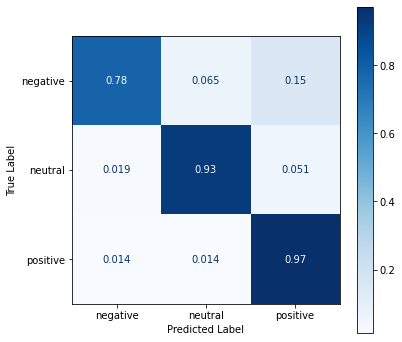

In [178]:
predictions = best_lsvc3_clf.predict(X_test3)

calc_and_display_performance_metric(classifer=best_lsvc3_clf, 
                                    Xtest=X_test3, 
                                    ytest=y_test3,
                                    Xtrain=X_train3,
                                    ytrain=y_train3,
                                    classifier_predictions=predictions,
                                    class_label_names=three_label_names)

--------------------------------------------------------------------------
Training Accuracy: 0.9974 		 Testing Accuracy: 0.9253
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.84      0.77      0.81      1251
     Neutral       0.87      0.84      0.85      1821
    Positive       0.95      0.97      0.96      8446

    accuracy                           0.93     11518
   macro avg       0.89      0.86      0.87     11518
weighted avg       0.92      0.93      0.92     11518

--------------------------------------------------------------------------


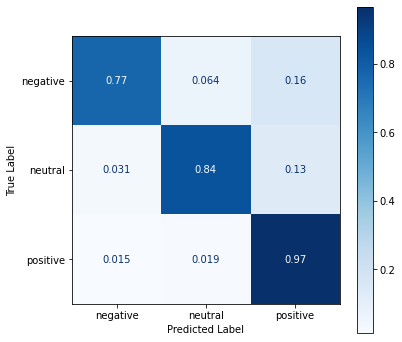

In [150]:
# 3 Class classifier Linear SVC
lsvc3_clf = Pipeline([('tfidf', vectorizer),
                       ('clf', LinearSVC(class_weight='balanced', max_iter=2000))
                    ])

lsvc3_clf.fit(X_train3, y_train3)
predictions = lsvc3_clf.predict(X_test3)

calc_and_display_performance_metric(classifer=lsvc3_clf, 
                                    Xtest=X_test3, 
                                    ytest=y_test3,
                                    Xtrain=X_train3,
                                    ytrain=y_train3,
                                    classifier_predictions=predictions,
                                    class_label_names=three_label_names)

--------------------------------------------------------------------------
Training Accuracy: 0.7727 		 Testing Accuracy: 0.7684
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.62      0.25      0.36      1251
     Neutral       0.96      0.16      0.27      1821
    Positive       0.77      0.98      0.86      8446

    accuracy                           0.77     11518
   macro avg       0.78      0.46      0.50     11518
weighted avg       0.78      0.77      0.71     11518

--------------------------------------------------------------------------


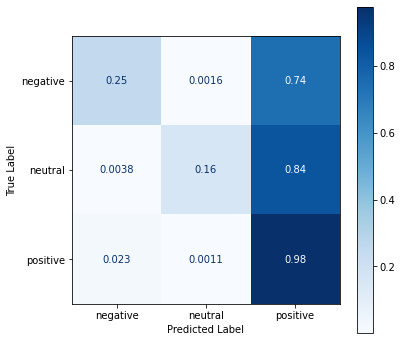

In [159]:
# SGDClassifier: Linear classifiers (SVM, logistic regression, etc.) with SGD training.
# The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM).
# 
# loss set equal to hinge will yield behaviour such as that of a SVC with a linear kernel
# penalty defaults to ‘l2’ which is the standard regularizer for linear SVM models.
# 

sgd_clf3 = Pipeline([('tfidf', vectorizer),
                    ('clf', SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=2000, class_weight='balanced'))
                    ])
sgd_clf3.fit(X_train3, y_train3)
predictions = sgd_clf3.predict(X_test3)

calc_and_display_performance_metric(classifer=sgd_clf3, 
                                    Xtest=X_test3, 
                                    ytest=y_test3,
                                    Xtrain=X_train3,
                                    ytrain=y_train3,
                                    classifier_predictions=predictions,
                                    class_label_names=three_label_names)


--------------------------------------------------------------------------
Training Accuracy: 0.9954 		 Testing Accuracy: 0.95
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.78      0.82      0.80      1193
    Positive       0.97      0.97      0.97      8506

    accuracy                           0.95      9699
   macro avg       0.88      0.89      0.89      9699
weighted avg       0.95      0.95      0.95      9699

--------------------------------------------------------------------------


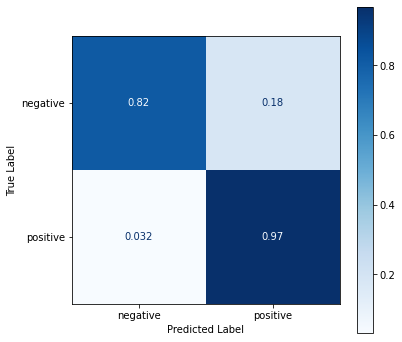

In [151]:
# 2 Class classifier Linear SVC
lsvc_clf = Pipeline([('tfidf', vectorizer),
                       ('clf', LinearSVC(class_weight='balanced', max_iter=2000))
                    ])

lsvc_clf.fit(X_train, y_train)
predictions = lsvc_clf.predict(X_test)

calc_and_display_performance_metric(classifer=lsvc_clf, 
                                    Xtest=X_test, 
                                    ytest=y_test,
                                    Xtrain=X_train,
                                    ytrain=y_train,
                                    classifier_predictions=predictions,
                                    class_label_names=two_label_names)

--------------------------------------------------------------------------
Training Accuracy: 1.0 		 Testing Accuracy: 0.8419
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.97      0.26      0.42      1251
     Neutral       0.91      0.55      0.68      1821
    Positive       0.83      0.99      0.90      8446

    accuracy                           0.84     11518
   macro avg       0.90      0.60      0.67     11518
weighted avg       0.86      0.84      0.82     11518

--------------------------------------------------------------------------


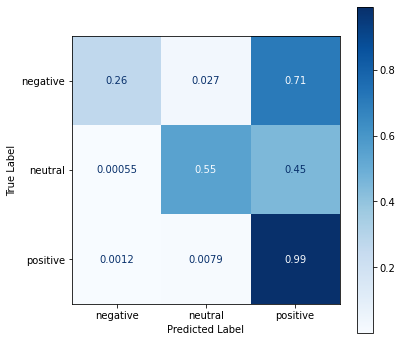

In [148]:
# 3 Class classifier - RandomForest
rf_clf3 = Pipeline([('tfidf', vectorizer),
                    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
                    ])

rf_clf3.fit(X_train3, y_train3)

predictions = rf_clf3.predict(X_test3)

calc_and_display_performance_metric(classifer=rf_clf3, 
                                    Xtest=X_test3, 
                                    ytest=y_test3,
                                    Xtrain=X_train3,
                                    ytrain=y_train3,
                                    classifier_predictions=predictions,
                                    class_label_names=three_label_names)

--------------------------------------------------------------------------
Training Accuracy: 1.0 		 Testing Accuracy: 0.9066
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.94      0.26      0.40      1193
    Positive       0.91      1.00      0.95      8506

    accuracy                           0.91      9699
   macro avg       0.92      0.63      0.68      9699
weighted avg       0.91      0.91      0.88      9699

--------------------------------------------------------------------------


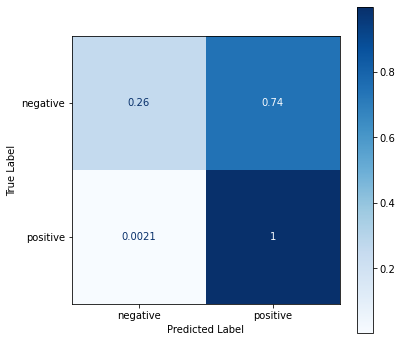

In [149]:
# 2 Class classifier - RandomForest
rf_clf = Pipeline([('tfidf', vectorizer),
                    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
                    ])

rf_clf.fit(X_train, y_train)

predictions = rf_clf.predict(X_test)

calc_and_display_performance_metric(classifer=rf_clf, 
                                    Xtest=X_test, 
                                    ytest=y_test,
                                    Xtrain=X_train,
                                    ytrain=y_train,
                                    classifier_predictions=predictions,
                                    class_label_names=two_label_names)

In [ ]:
# Try out picking the trained model and loading it back in when/if there is new data to test it on.
# ex:
# model.fit(X_train, X_test)
# #Pickel the trained model
# with open('fitted_model.pickle', 'wb') as modelFile:
#      pickle.dump(model, modelFile)
#
# #Load pre-trained model - no need to retrain it again
# with open('itted_model.pickle', 'rb') as modelFile:
#    model = pickle.load(modelFile)
#
# #Predict with new data
# prediction = model.predict(new_data)